# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\Rishabh Sharma\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


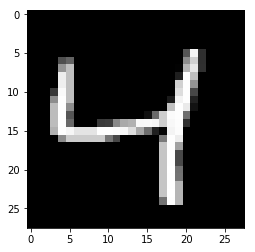

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name="inputs")
targets_ = tf.placeholder(tf.float32,(None,28,28,1),name="outputs")

### Encoder
conv1 = tf.layers.conv2d(inputs_,16,(3,3),padding="same",activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding="same")
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2,(2,2),(2,2),padding="Same")
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2,8,(3,3),padding="Same",activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv4,(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3,16,(3,3),padding="Same",activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7041
Epoch: 1/20... Training loss: 0.6956
Epoch: 1/20... Training loss: 0.6883
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6754
Epoch: 1/20... Training loss: 0.6691
Epoch: 1/20... Training loss: 0.6623
Epoch: 1/20... Training loss: 0.6552
Epoch: 1/20... Training loss: 0.6483
Epoch: 1/20... Training loss: 0.6399
Epoch: 1/20... Training loss: 0.6324
Epoch: 1/20... Training loss: 0.6243
Epoch: 1/20... Training loss: 0.6161
Epoch: 1/20... Training loss: 0.6028
Epoch: 1/20... Training loss: 0.6019
Epoch: 1/20... Training loss: 0.5915
Epoch: 1/20... Training loss: 0.5886
Epoch: 1/20... Training loss: 0.5776
Epoch: 1/20... Training loss: 0.5769
Epoch: 1/20... Training loss: 0.5720
Epoch: 1/20... Training loss: 0.5699
Epoch: 1/20... Training loss: 0.5576
Epoch: 1/20... Training loss: 0.5506
Epoch: 1/20... Training loss: 0.5554
Epoch: 1/20... Training loss: 0.5461
Epoch: 1/20... Training loss: 0.5222
Epoch: 1/20... Training loss: 0.5197
E

Epoch: 1/20... Training loss: 0.1124
Epoch: 1/20... Training loss: 0.1092
Epoch: 1/20... Training loss: 0.1097
Epoch: 1/20... Training loss: 0.1114
Epoch: 1/20... Training loss: 0.1056
Epoch: 1/20... Training loss: 0.1080
Epoch: 1/20... Training loss: 0.1074
Epoch: 1/20... Training loss: 0.1054
Epoch: 1/20... Training loss: 0.1071
Epoch: 1/20... Training loss: 0.1085
Epoch: 1/20... Training loss: 0.1092
Epoch: 1/20... Training loss: 0.1065
Epoch: 1/20... Training loss: 0.1053
Epoch: 1/20... Training loss: 0.1075
Epoch: 1/20... Training loss: 0.1099
Epoch: 1/20... Training loss: 0.1051
Epoch: 1/20... Training loss: 0.1061
Epoch: 1/20... Training loss: 0.1056
Epoch: 1/20... Training loss: 0.1089
Epoch: 1/20... Training loss: 0.1046
Epoch: 1/20... Training loss: 0.1061
Epoch: 1/20... Training loss: 0.1101
Epoch: 1/20... Training loss: 0.1049
Epoch: 1/20... Training loss: 0.1047
Epoch: 1/20... Training loss: 0.1052
Epoch: 1/20... Training loss: 0.1049
Epoch: 1/20... Training loss: 0.1058
E

Epoch: 2/20... Training loss: 0.0918
Epoch: 2/20... Training loss: 0.0946
Epoch: 2/20... Training loss: 0.0948
Epoch: 2/20... Training loss: 0.0921
Epoch: 2/20... Training loss: 0.0926
Epoch: 2/20... Training loss: 0.0928
Epoch: 2/20... Training loss: 0.0912
Epoch: 2/20... Training loss: 0.0901
Epoch: 2/20... Training loss: 0.0981
Epoch: 2/20... Training loss: 0.0958
Epoch: 2/20... Training loss: 0.0944
Epoch: 2/20... Training loss: 0.0955
Epoch: 2/20... Training loss: 0.0931
Epoch: 2/20... Training loss: 0.0964
Epoch: 2/20... Training loss: 0.0953
Epoch: 2/20... Training loss: 0.0919
Epoch: 2/20... Training loss: 0.0975
Epoch: 2/20... Training loss: 0.0936
Epoch: 2/20... Training loss: 0.0942
Epoch: 2/20... Training loss: 0.0901
Epoch: 2/20... Training loss: 0.0926
Epoch: 2/20... Training loss: 0.0962
Epoch: 2/20... Training loss: 0.0940
Epoch: 2/20... Training loss: 0.0937
Epoch: 2/20... Training loss: 0.0916
Epoch: 2/20... Training loss: 0.0906
Epoch: 2/20... Training loss: 0.0926
E

Epoch: 3/20... Training loss: 0.0903
Epoch: 3/20... Training loss: 0.0862
Epoch: 3/20... Training loss: 0.0857
Epoch: 3/20... Training loss: 0.0872
Epoch: 3/20... Training loss: 0.0868
Epoch: 3/20... Training loss: 0.0894
Epoch: 3/20... Training loss: 0.0841
Epoch: 3/20... Training loss: 0.0887
Epoch: 3/20... Training loss: 0.0895
Epoch: 3/20... Training loss: 0.0887
Epoch: 3/20... Training loss: 0.0885
Epoch: 3/20... Training loss: 0.0915
Epoch: 3/20... Training loss: 0.0876
Epoch: 3/20... Training loss: 0.0857
Epoch: 3/20... Training loss: 0.0874
Epoch: 3/20... Training loss: 0.0884
Epoch: 3/20... Training loss: 0.0891
Epoch: 3/20... Training loss: 0.0847
Epoch: 3/20... Training loss: 0.0859
Epoch: 3/20... Training loss: 0.0869
Epoch: 3/20... Training loss: 0.0854
Epoch: 3/20... Training loss: 0.0884
Epoch: 3/20... Training loss: 0.0849
Epoch: 3/20... Training loss: 0.0847
Epoch: 3/20... Training loss: 0.0868
Epoch: 3/20... Training loss: 0.0879
Epoch: 3/20... Training loss: 0.0882
E

Epoch: 4/20... Training loss: 0.0826
Epoch: 4/20... Training loss: 0.0850
Epoch: 4/20... Training loss: 0.0853
Epoch: 4/20... Training loss: 0.0823
Epoch: 4/20... Training loss: 0.0834
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0817
Epoch: 4/20... Training loss: 0.0812
Epoch: 4/20... Training loss: 0.0849
Epoch: 4/20... Training loss: 0.0804
Epoch: 4/20... Training loss: 0.0854
Epoch: 4/20... Training loss: 0.0824
Epoch: 4/20... Training loss: 0.0838
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0848
Epoch: 4/20... Training loss: 0.0870
Epoch: 4/20... Training loss: 0.0811
Epoch: 4/20... Training loss: 0.0827
Epoch: 4/20... Training loss: 0.0837
Epoch: 4/20... Training loss: 0.0822
Epoch: 4/20... Training loss: 0.0802
Epoch: 4/20... Training loss: 0.0842
Epoch: 4/20... Training loss: 0.0834
Epoch: 4/20... Training loss: 0.0830
Epoch: 4/20... Training loss: 0.0857
Epoch: 4/20... Training loss: 0.0831
Epoch: 4/20... Training loss: 0.0860
E

Epoch: 4/20... Training loss: 0.0840
Epoch: 4/20... Training loss: 0.0793
Epoch: 4/20... Training loss: 0.0825
Epoch: 4/20... Training loss: 0.0800
Epoch: 4/20... Training loss: 0.0830
Epoch: 4/20... Training loss: 0.0826
Epoch: 4/20... Training loss: 0.0828
Epoch: 4/20... Training loss: 0.0823
Epoch: 4/20... Training loss: 0.0785
Epoch: 4/20... Training loss: 0.0810
Epoch: 4/20... Training loss: 0.0798
Epoch: 4/20... Training loss: 0.0803
Epoch: 4/20... Training loss: 0.0831
Epoch: 4/20... Training loss: 0.0837
Epoch: 4/20... Training loss: 0.0833
Epoch: 4/20... Training loss: 0.0821
Epoch: 4/20... Training loss: 0.0818
Epoch: 4/20... Training loss: 0.0843
Epoch: 4/20... Training loss: 0.0833
Epoch: 4/20... Training loss: 0.0842
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0845
Epoch: 4/20... Training loss: 0.0816
Epoch: 4/20... Training loss: 0.0825
Epoch: 4/20... Training loss: 0.0799
Epoch: 4/20... Training loss: 0.0801
Epoch: 4/20... Training loss: 0.0790
E

Epoch: 5/20... Training loss: 0.0793
Epoch: 5/20... Training loss: 0.0803
Epoch: 5/20... Training loss: 0.0791
Epoch: 5/20... Training loss: 0.0801
Epoch: 5/20... Training loss: 0.0766
Epoch: 5/20... Training loss: 0.0820
Epoch: 5/20... Training loss: 0.0792
Epoch: 5/20... Training loss: 0.0828
Epoch: 5/20... Training loss: 0.0831
Epoch: 5/20... Training loss: 0.0789
Epoch: 5/20... Training loss: 0.0790
Epoch: 5/20... Training loss: 0.0825
Epoch: 5/20... Training loss: 0.0792
Epoch: 5/20... Training loss: 0.0817
Epoch: 5/20... Training loss: 0.0810
Epoch: 5/20... Training loss: 0.0785
Epoch: 5/20... Training loss: 0.0820
Epoch: 5/20... Training loss: 0.0813
Epoch: 5/20... Training loss: 0.0782
Epoch: 5/20... Training loss: 0.0812
Epoch: 5/20... Training loss: 0.0788
Epoch: 5/20... Training loss: 0.0791
Epoch: 5/20... Training loss: 0.0818
Epoch: 5/20... Training loss: 0.0804
Epoch: 5/20... Training loss: 0.0802
Epoch: 5/20... Training loss: 0.0780
Epoch: 5/20... Training loss: 0.0811
E

Epoch: 6/20... Training loss: 0.0820
Epoch: 6/20... Training loss: 0.0784
Epoch: 6/20... Training loss: 0.0817
Epoch: 6/20... Training loss: 0.0800
Epoch: 6/20... Training loss: 0.0801
Epoch: 6/20... Training loss: 0.0785
Epoch: 6/20... Training loss: 0.0802
Epoch: 6/20... Training loss: 0.0828
Epoch: 6/20... Training loss: 0.0819
Epoch: 6/20... Training loss: 0.0838
Epoch: 6/20... Training loss: 0.0813
Epoch: 6/20... Training loss: 0.0789
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0801
Epoch: 6/20... Training loss: 0.0803
Epoch: 6/20... Training loss: 0.0792
Epoch: 6/20... Training loss: 0.0767
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0782
Epoch: 6/20... Training loss: 0.0795
Epoch: 6/20... Training loss: 0.0790
Epoch: 6/20... Training loss: 0.0806
Epoch: 6/20... Training loss: 0.0798
Epoch: 6/20... Training loss: 0.0805
Epoch: 6/20... Training loss: 0.0786
Epoch: 6/20... Training loss: 0.0807
Epoch: 6/20... Training loss: 0.0803
E

Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0763
Epoch: 7/20... Training loss: 0.0804
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0767
Epoch: 7/20... Training loss: 0.0756
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0802
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0797
Epoch: 7/20... Training loss: 0.0772
Epoch: 7/20... Training loss: 0.0773
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0794
Epoch: 7/20... Training loss: 0.0788
Epoch: 7/20... Training loss: 0.0803
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0783
Epoch: 7/20... Training loss: 0.0761
Epoch: 7/20... Training loss: 0.0785
Epoch: 7/20... Training loss: 0.0794
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0788
Epoch: 7/20... Training loss: 0.0780
Epoch: 7/20... Training loss: 0.0813
Epoch: 7/20... Training loss: 0.0761
E

Epoch: 7/20... Training loss: 0.0790
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0776
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0769
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0805
Epoch: 7/20... Training loss: 0.0784
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0781
Epoch: 7/20... Training loss: 0.0817
Epoch: 7/20... Training loss: 0.0778
Epoch: 7/20... Training loss: 0.0765
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0787
Epoch: 7/20... Training loss: 0.0793
Epoch: 7/20... Training loss: 0.0808
Epoch: 7/20... Training loss: 0.0767
Epoch: 7/20... Training loss: 0.0793
Epoch: 7/20... Training loss: 0.0797
Epoch: 7/20... Training loss: 0.0763
Epoch: 7/20... Training loss: 0.0786
Epoch: 7/20... Training loss: 0.0752
Epoch: 7/20... Training loss: 0.0748
Epoch: 7/20... Training loss: 0.0779
Epoch: 7/20... Training loss: 0.0769
E

Epoch: 8/20... Training loss: 0.0772
Epoch: 8/20... Training loss: 0.0773
Epoch: 8/20... Training loss: 0.0757
Epoch: 8/20... Training loss: 0.0769
Epoch: 8/20... Training loss: 0.0778
Epoch: 8/20... Training loss: 0.0774
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0757
Epoch: 8/20... Training loss: 0.0765
Epoch: 8/20... Training loss: 0.0781
Epoch: 8/20... Training loss: 0.0807
Epoch: 8/20... Training loss: 0.0787
Epoch: 8/20... Training loss: 0.0792
Epoch: 8/20... Training loss: 0.0741
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0770
Epoch: 8/20... Training loss: 0.0777
Epoch: 8/20... Training loss: 0.0780
Epoch: 8/20... Training loss: 0.0763
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0771
Epoch: 8/20... Training loss: 0.0743
Epoch: 8/20... Training loss: 0.0755
Epoch: 8/20... Training loss: 0.0793
Epoch: 8/20... Training loss: 0.0775
Epoch: 8/20... Training loss: 0.0762
E

Epoch: 9/20... Training loss: 0.0784
Epoch: 9/20... Training loss: 0.0780
Epoch: 9/20... Training loss: 0.0767
Epoch: 9/20... Training loss: 0.0783
Epoch: 9/20... Training loss: 0.0794
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0774
Epoch: 9/20... Training loss: 0.0785
Epoch: 9/20... Training loss: 0.0766
Epoch: 9/20... Training loss: 0.0781
Epoch: 9/20... Training loss: 0.0757
Epoch: 9/20... Training loss: 0.0755
Epoch: 9/20... Training loss: 0.0778
Epoch: 9/20... Training loss: 0.0750
Epoch: 9/20... Training loss: 0.0747
Epoch: 9/20... Training loss: 0.0754
Epoch: 9/20... Training loss: 0.0776
Epoch: 9/20... Training loss: 0.0773
Epoch: 9/20... Training loss: 0.0777
Epoch: 9/20... Training loss: 0.0786
Epoch: 9/20... Training loss: 0.0758
Epoch: 9/20... Training loss: 0.0743
Epoch: 9/20... Training loss: 0.0766
Epoch: 9/20... Training loss: 0.0771
Epoch: 9/20... Training loss: 0.0779
Epoch: 9/20... Training loss: 0.0756
Epoch: 9/20... Training loss: 0.0777
E

Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0778
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0768
Epoch: 10/20... Training loss: 0.0794
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0754
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0766
Epoch: 10/20... Training loss: 0.0783
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0749
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0761
Epoch: 10/20... Training loss: 0.0768
Epoch: 10/20... Training loss: 0.0781
Epoch: 10/20... Training loss: 0.0780
Epoch: 10/20... Training loss: 0.0777
Epoch: 10/20... Training loss: 0.0761
Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0773
Epoch: 10/20... Training loss: 0.0765
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0752
Epoch: 10/20... Training loss: 0.0764
Epoch: 10/20

Epoch: 10/20... Training loss: 0.0772
Epoch: 10/20... Training loss: 0.0745
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20... Training loss: 0.0757
Epoch: 10/20... Training loss: 0.0782
Epoch: 10/20... Training loss: 0.0734
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0755
Epoch: 10/20... Training loss: 0.0788
Epoch: 10/20... Training loss: 0.0753
Epoch: 10/20... Training loss: 0.0770
Epoch: 10/20... Training loss: 0.0767
Epoch: 10/20... Training loss: 0.0733
Epoch: 10/20... Training loss: 0.0759
Epoch: 10/20... Training loss: 0.0777
Epoch: 10/20... Training loss: 0.0774
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0769
Epoch: 10/20... Training loss: 0.0749
Epoch: 10/20... Training loss: 0.0741
Epoch: 10/20... Training loss: 0.0766
Epoch: 10/20... Training loss: 0.0772
Epoch: 10/20... Training loss: 0.0760
Epoch: 10/20... Training loss: 0.0758
Epoch: 10/20... Training loss: 0.0745
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0755
Epoch: 11/20... Training loss: 0.0740
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0771
Epoch: 11/20... Training loss: 0.0756
Epoch: 11/20... Training loss: 0.0760
Epoch: 11/20... Training loss: 0.0747
Epoch: 11/20... Training loss: 0.0750
Epoch: 11/20... Training loss: 0.0761
Epoch: 11/20... Training loss: 0.0750
Epoch: 11/20... Training loss: 0.0745
Epoch: 11/20... Training loss: 0.0786
Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20... Training loss: 0.0749
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20... Training loss: 0.0764
Epoch: 11/20... Training loss: 0.0738
Epoch: 11/20... Training loss: 0.0779
Epoch: 11/20... Training loss: 0.0765
Epoch: 11/20... Training loss: 0.0759
Epoch: 11/20... Training loss: 0.0764
Epoch: 11/20... Training loss: 0.0738
Epoch: 11/20... Training loss: 0.0746
Epoch: 11/20... Training loss: 0.0762
Epoch: 11/20... Training loss: 0.0762
Epoch: 11/20... Training loss: 0.0754
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0744
Epoch: 12/20... Training loss: 0.0776
Epoch: 12/20... Training loss: 0.0725
Epoch: 12/20... Training loss: 0.0760
Epoch: 12/20... Training loss: 0.0753
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0771
Epoch: 12/20... Training loss: 0.0740
Epoch: 12/20... Training loss: 0.0776
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0751
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0746
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0754
Epoch: 12/20... Training loss: 0.0745
Epoch: 12/20... Training loss: 0.0757
Epoch: 12/20... Training loss: 0.0761
Epoch: 12/20... Training loss: 0.0752
Epoch: 12/20... Training loss: 0.0742
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0728
Epoch: 12/20... Training loss: 0.0748
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0755
Epoch: 12/20... Training loss: 0.0763
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0748
Epoch: 12/20... Training loss: 0.0753
Epoch: 12/20... Training loss: 0.0732
Epoch: 12/20... Training loss: 0.0702
Epoch: 12/20... Training loss: 0.0763
Epoch: 12/20... Training loss: 0.0770
Epoch: 12/20... Training loss: 0.0741
Epoch: 12/20... Training loss: 0.0747
Epoch: 12/20... Training loss: 0.0730
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0733
Epoch: 12/20... Training loss: 0.0723
Epoch: 12/20... Training loss: 0.0735
Epoch: 12/20... Training loss: 0.0756
Epoch: 12/20... Training loss: 0.0743
Epoch: 12/20... Training loss: 0.0749
Epoch: 12/20... Training loss: 0.0736
Epoch: 13/20... Training loss: 0.0730
Epoch: 13/20... Training loss: 0.0751
Epoch: 13/20... Training loss: 0.0749
Epoch: 13/20... Training loss: 0.0767
Epoch: 13/20... Training loss: 0.0719
Epoch: 13/20... Training loss: 0.0753
Epoch: 13/20

Epoch: 13/20... Training loss: 0.0763
Epoch: 13/20... Training loss: 0.0758
Epoch: 13/20... Training loss: 0.0757
Epoch: 13/20... Training loss: 0.0732
Epoch: 13/20... Training loss: 0.0754
Epoch: 13/20... Training loss: 0.0724
Epoch: 13/20... Training loss: 0.0745
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0741
Epoch: 13/20... Training loss: 0.0752
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0727
Epoch: 13/20... Training loss: 0.0742
Epoch: 13/20... Training loss: 0.0760
Epoch: 13/20... Training loss: 0.0768
Epoch: 13/20... Training loss: 0.0752
Epoch: 13/20... Training loss: 0.0743
Epoch: 13/20... Training loss: 0.0733
Epoch: 13/20... Training loss: 0.0771
Epoch: 13/20... Training loss: 0.0759
Epoch: 13/20... Training loss: 0.0748
Epoch: 13/20... Training loss: 0.0746
Epoch: 13/20... Training loss: 0.0763
Epoch: 13/20... Training loss: 0.0761
Epoch: 13/20... Training loss: 0.0722
Epoch: 13/20... Training loss: 0.0747
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0737
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0756
Epoch: 14/20... Training loss: 0.0735
Epoch: 14/20... Training loss: 0.0712
Epoch: 14/20... Training loss: 0.0761
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0745
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0751
Epoch: 14/20... Training loss: 0.0739
Epoch: 14/20... Training loss: 0.0738
Epoch: 14/20... Training loss: 0.0753
Epoch: 14/20... Training loss: 0.0747
Epoch: 14/20... Training loss: 0.0762
Epoch: 14/20... Training loss: 0.0729
Epoch: 14/20... Training loss: 0.0730
Epoch: 14/20... Training loss: 0.0760
Epoch: 14/20... Training loss: 0.0752
Epoch: 14/20... Training loss: 0.0732
Epoch: 14/20... Training loss: 0.0741
Epoch: 14/20... Training loss: 0.0736
Epoch: 14/20... Training loss: 0.0738
Epoch: 14/20... Training loss: 0.0733
Epoch: 14/20... Training loss: 0.0734
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20... Training loss: 0.0740
Epoch: 15/20... Training loss: 0.0725
Epoch: 15/20... Training loss: 0.0741
Epoch: 15/20... Training loss: 0.0762
Epoch: 15/20... Training loss: 0.0766
Epoch: 15/20... Training loss: 0.0744
Epoch: 15/20... Training loss: 0.0732
Epoch: 15/20... Training loss: 0.0728
Epoch: 15/20... Training loss: 0.0722
Epoch: 15/20... Training loss: 0.0751
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0755
Epoch: 15/20... Training loss: 0.0767
Epoch: 15/20... Training loss: 0.0749
Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20... Training loss: 0.0717
Epoch: 15/20... Training loss: 0.0729
Epoch: 15/20... Training loss: 0.0725
Epoch: 15/20... Training loss: 0.0747
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0739
Epoch: 15/20... Training loss: 0.0724
Epoch: 15/20... Training loss: 0.0737
Epoch: 15/20... Training loss: 0.0751
Epoch: 15/20... Training loss: 0.0735
Epoch: 15/20

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = 
# Now 28x28x32
maxpool1 = 
# Now 14x14x32
conv2 = 
# Now 14x14x32
maxpool2 = 
# Now 7x7x32
conv3 = 
# Now 7x7x16
encoded = 
# Now 4x4x16

### Decoder
upsample1 = 
# Now 7x7x16
conv4 = 
# Now 7x7x16
upsample2 = 
# Now 14x14x16
conv5 = 
# Now 14x14x32
upsample3 = 
# Now 28x28x32
conv6 = 
# Now 28x28x32

logits = 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)